# Single Subject Segmentation Q1K

In [1]:
# import packages
#import q1k_sync_tools as qst
import mne
import mne_bids
#mne.viz.set_browser_backend('qt')
#%matplotlib qt
#pd.options.mode.chained_assignment = None
#import pylossless as ll
#import numpy as np
import pandas as pd
#import glob

from pathlib import Path
import shutil
import pylossless as ll


<frozen importlib._bootstrap>:241: RuntimeWarning: The MNE-Python config file (/home/james/.mne/mne-python.json) is not a valid JSON file and might be corrupted
/home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossless/derivatives/q1k_postproc/code/q1k_postproc_erp/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
project_path = "/home/james/q1k/pilot/q1k-external-pilot/"
pylossless_path = "derivatives/pylossless/"
postproc_path = "derivatives/q1k_postproc/"
task_id_in = "mn"
task_id_out = "mn"
subject_id = '096'
session_id = '01'

bids_path = mne_bids.BIDSPath(
    subject=subject_id, session=session_id, task=task_id_out, run="1", datatype="eeg", suffix="eeg",root=project_path + pylossless_path
)
print(bids_path)

/home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossless/sub-096/ses-01/eeg/sub-096_ses-01_task-mn_run-1_eeg.edf


In [3]:
bids_path

BIDSPath(
root: /home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossless
datatype: eeg
basename: sub-096_ses-01_task-mn_run-1_eeg)

In [4]:
# Read the BIDS pylossless output file..
eeg_raw = mne_bids.read_raw_bids(bids_path=bids_path, verbose=False)

/tmp/ipykernel_70058/260111430.py:2: RuntimeWarning: participants.tsv file not found for /home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossless/sub-096/ses-01/eeg/sub-096_ses-01_task-mn_run-1_eeg.edf
  eeg_raw = mne_bids.read_raw_bids(bids_path=bids_path, verbose=False)


In [5]:
# Get the events form the annotations
eeg_events, eeg_event_dict  = mne.events_from_annotations(eeg_raw)

Used Annotations descriptions: ['DIN4', 'mmns', 'mmns_d', 'mmnt', 'mmnt_d']


In [6]:
ll_state = ll.LosslessPipeline()
ll_state = ll_state.load_ll_derivative(bids_path)

Extracting EDF parameters from /home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossless/sub-096/ses-01/eeg/sub-096_ses-01_task-mn_run-1_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossless/sub-096/ses-01/eeg/sub-096_ses-01_task-mn_run-1_events.tsv.
Reading channel info from /home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossless/sub-096/ses-01/eeg/sub-096_ses-01_task-mn_run-1_channels.tsv.
Reading electrode coords from /home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossless/sub-096/ses-01/eeg/sub-096_ses-01_space-CapTrak_electrodes.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading /home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossless/sub-096/ses-01/eeg/sub-096_ses-01_task-mn_run-1_ica1_ica.fif ...
Now restoring ICA solution ...
Ready.
Reading /home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossles

/home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossless/derivatives/q1k_postproc/code/q1k_postproc_erp/env/lib/python3.10/site-packages/pylossless/pipeline.py:1198: RuntimeWarning: participants.tsv file not found for /home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossless/sub-096/ses-01/eeg/sub-096_ses-01_task-mn_run-1_eeg.edf
  self.raw = mne_bids.read_raw_bids(derivatives_path)


In [7]:
bids_path_str=str(bids_path)
# Merge marks down to bads (aka manual)
ll_qcr = ll_state.raw.copy()
manual = []
for flag_type in ll_state.flags['ch']:
    manual.extend(ll_state.flags['ch'][flag_type])
print(ll_state.flags['ch'])
ll_qcr.info['bads'].extend(manual)
ll_qcr.info['bads'] = list(set(ll_qcr.info['bads']))

# Read the ICLabel info from file and add to exclude
df = pd.read_csv(bids_path_str.replace('_eeg.edf', '_iclabels.tsv'), sep='\t')
ll_state.ica2.exclude = list(df[df['ic_type'].str.match('eog|muscle|ch_noise|ecg')].index)

# Load the data and apply the ICA
ll_qcr.load_data()
ll_state.ica2.apply(ll_qcr)
ll_qcr = ll_qcr.filter(l_freq=1.0, h_freq=40.0)
ll_qcr = ll_qcr.set_eeg_reference(ref_channels="average")
ll_qcr

Flagged channels: |
  Noisy: None
  Bridged: None
  Uncorrelated: None
  Rank: ['E17']

Reading 0 ... 202999  =      0.000 ...   202.999 secs...
Applying ICA to Raw instance
    Transforming to ICA space (101 components)
    Zeroing out 17 ICA components
    Projecting back using 102 PCA components
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



/tmp/ipykernel_70058/198115934.py:18: RuntimeWarning: The MNE-Python config file (/home/james/.mne/mne-python.json) is not a valid JSON file and might be corrupted
  ll_qcr = ll_qcr.filter(l_freq=1.0, h_freq=40.0)
/tmp/ipykernel_70058/198115934.py:18: RuntimeWarning: The MNE-Python config file (/home/james/.mne/mne-python.json) is not a valid JSON file and might be corrupted
  ll_qcr = ll_qcr.filter(l_freq=1.0, h_freq=40.0)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossless/derivatives/q1k_postproc/code/q1k_postproc_erp/env/lib/python3.10/site-packages/IPython/core/formatters.py:347: RuntimeWarning: The MNE-Python config file (/home/james/.mne/mne-python.json) is not a valid JSON file and might be corrupted
  return method()
/home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossless/derivatives/q1k_postproc/code/q1k_postproc_erp/env/lib/python3.10/site-packages/IPython/core/formatters.py:347: RuntimeWarning: The MNE-Python config file (/home/james/.mne/mne-python.json) is not a valid JSON file and might be corrupted
  return method()


<RawEDF | sub-096_ses-01_task-mn_run-1_eeg.edf, 129 x 203000 (203.0 s), ~200.0 MB, data loaded>

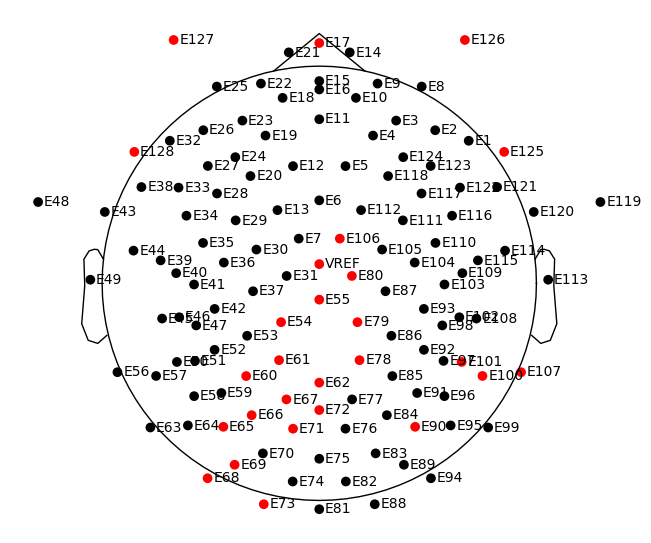

In [8]:
fig = ll_qcr.plot_sensors(show_names=True)

In [9]:
# Relabel condition vars for niceness
eeg_event_dict['mmn/standard/disp/mmns'] = eeg_event_dict.pop('mmns')
eeg_event_dict['mmn/target/disp/mmnt'] = eeg_event_dict.pop('mmnt')

In [10]:
# Epoch structure is created for ALL events, then you 'segment' by indexing into it
epochs = mne.Epochs(ll_qcr, eeg_events, event_id=eeg_event_dict, tmin=-1, tmax=2.0, on_missing='warn', event_repeated='drop')

Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
240 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated


In [11]:
# Check trial counts
epochs[['mmns', 'mmnt']]

/home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossless/derivatives/q1k_postproc/code/q1k_postproc_erp/env/lib/python3.10/site-packages/IPython/core/formatters.py:347: RuntimeWarning: The MNE-Python config file (/home/james/.mne/mne-python.json) is not a valid JSON file and might be corrupted
  return method()


Number of events,58
Events,mmn/standard/disp/mmns: 49mmn/target/disp/mmnt: 9
Time range,-1.000 – 2.000 s
Baseline,-1.000 – 0.000 s


combining channels using "mean"
combining channels using "mean"


/tmp/ipykernel_70058/1236447215.py:3: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(evokeds, picks=['E62'], combine='mean')


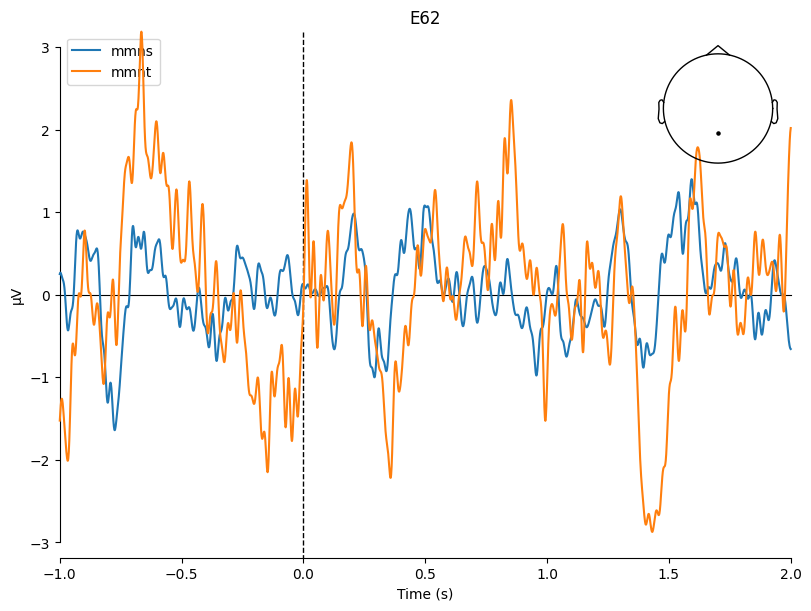

[<Figure size 800x600 with 2 Axes>]

In [12]:
# Plot ERPs
evokeds = {'mmns': epochs['mmns'].average(), 'mmnt': epochs['mmnt'].average()}
mne.viz.plot_compare_evokeds(evokeds, picks=['E62'], combine='mean')

In [13]:
mne.write_evokeds(project_path + pylossless_path + postproc_path + 'erp_fif_files/mn/' + bids_path.basename + '_erp.fif',list(evokeds.values()), overwrite=True)

/tmp/ipykernel_70058/3848142848.py:1: RuntimeWarning: This filename (/home/james/q1k/pilot/q1k-external-pilot/derivatives/pylossless/derivatives/q1k_postproc/erp_fif_files/mn/sub-096_ses-01_task-mn_run-1_eeg_erp.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz
  mne.write_evokeds(project_path + pylossless_path + postproc_path + 'erp_fif_files/mn/' + bids_path.basename + '_erp.fif',list(evokeds.values()), overwrite=True)


In [ ]:
# Plot channel data only
mne.viz.plot_raw(eeg_raw, events=eeg_events, event_id=eeg_event_dict)

In [ ]:
# set file variables
#subject_raw_eeg = glob.glob('sourcedata/020_1/020_1_go_*.mff')
subject_raw_eeg = 'sourcedata/012_1/012_1_eeg/012_vp_20230417_125533.mff'
subject_raw_et = 'sourcedata/012_1/012_1_eyetracking/012_vp_1.asc'
subject_derivative = 'output_vp/derivatives/pylossless/sub-012/eeg/sub-012_task-vp_eeg.edf'
task_code = 'vp'

In [ ]:
subject_raw_eeg

In [ ]:
# Load EEG recording
eeg_raw = mne.io.read_raw_egi(subject_raw_eeg)

# Get event info from source recording
eeg_events = mne.find_events(eeg_raw, shortest_event=1)
eeg_event_dict = qst.get_event_dict(eeg_raw, eeg_events)



# Below is for syncing EEG and ET sessions then combining the data.

# Infer new events and labels from EEG paradigm procedure
#eeg_events, eeg_stims, eeg_iti, eeg_event_dict = qst.eeg_event_test(eeg_events, eeg_event_dict, task_name=task_code)

# Read eyetracking data and extact events
#et_raw = mne.io.read_raw_eyelink(subject_raw_et)
#et_annot_events, et_annot_event_dict = mne.events_from_annotations(et_raw)
#et_raw_df = et_raw.to_data_frame()

# Infer new events from paradigm procedure
#et_event_raw_df, et_events, et_stims, et_iti = qst.et_event_test(et_raw_df, task_name=task_code)

# Meld both ET and EEG together into new raw structure
#eeg_et_raw = qst.eeg_et_combine(eeg_raw, et_raw, eeg_stims, et_stims)

# Using the melded raw, build final event objects
#eeg_et_events = mne.find_events(eeg_et_raw, shortest_event=1)
#eeg_et_event_dict = qst.get_event_dict(eeg_et_raw, eeg_et_events)

# Free up memory
#del et_event_raw_df
#del et_events
#del et_stims
#del et_iti
#del et_raw_df
#del et_annot_events
#del et_annot_event_dict
#del eeg_events
#del eeg_stims
#del eeg_iti
#del eeg_event_dict

In [ ]:
eeg_events

In [ ]:
eeg_event_dict

In [ ]:
# Plot channel data only
mne.viz.plot_raw(eeg_raw, events=eeg_events, event_id=eeg_event_dict)

In [ ]:
# Plot channel data only
mne.viz.plot_raw(ll_state.raw, events=eeg_events, event_id=eeg_event_dict)

In [ ]:
# Plot comonents
ll_state.ica2.plot_sources(ll_state.raw)


In [ ]:
# Plot topos
ll_state.ica2.plot_components(inst=ll_state.raw)

In [ ]:
# Merge marks down to bads (aka manual)
ll_qcr = ll_state.raw.copy()
manual = []
for flag_type in ll_state.flags['ch']:
    manual.extend(ll_state.flags['ch'][flag_type])
print(ll_state.flags['ch'])
ll_qcr.info['bads'].extend(manual)
ll_qcr.info['bads'] = list(set(ll_qcr.info['bads']))

# Read the ICLabel info from file and add to exclude
df = pd.read_csv(subject_derivative.replace('_eeg.edf', '_iclabels.tsv'), sep='\t')
ll_state.ica2.exclude = list(df[df['ic_type'].str.match('eog|muscle|ch_noise|ecg')].index)

# Load the data and apply the ICA
ll_qcr.load_data()
ll_state.ica2.apply(ll_qcr)
ll_qcr = ll_qcr.filter(l_freq=1.0, h_freq=40.0)
ll_qcr = ll_qcr.set_eeg_reference(ref_channels="average")
ll_qcr

In [ ]:
# Plot cleaned data
mne.viz.plot_raw(ll_qcr, events=eeg_events, event_id=eeg_event_dict)

In [ ]:
# Take a look at the event dictionairy
eeg_event_dict

In [ ]:
# Relabel condition vars for niceness
eeg_event_dict['fq06hz/target/disp/dstr'] = eeg_event_dict.pop('dstr')
eeg_event_dict['fq15hz/target/disp/fvct'] = eeg_event_dict.pop('fvct')

In [ ]:
# Epoch structure is created for ALL events, then you 'segment' by indexing into it
epochs = mne.Epochs(ll_qcr, eeg_events, event_id=eeg_event_dict, tmin=-1, tmax=2.0, on_missing='warn', event_repeated='drop')

In [ ]:
# Check trial counts
epochs[['fq06hz', 'fq15hz']]

In [ ]:
# Plot ERPs
evokeds = {'fq06hz': epochs['fq06hz'].average(), 'fq15hz': epochs['fq15hz'].average()}
mne.viz.plot_compare_evokeds(evokeds, picks=['E70'], combine='mean')

In [ ]:
mne.write_evokeds(f'erp_fif_files/vp/009_1_vp_ave.fif',list(evokeds.values()), overwrite=True)

In [ ]:
eeg_events

In [ ]:
mask = np.isin(eeg_events[:,2],[eeg_event_dict['fq15hz/target/disp/fvct']])
eeg_events = eeg_events[mask]


epochs = mne.Epochs(ll_qcr, eeg_events, event_id=eeg_event_dict, tmin=-1.0, tmax=2.0, on_missing='warn', event_repeated='merge')

freqs = np.arange(5,50,2)
n_cycles = freqs / 2.0  # different number of cycle per frequency
power, itc = mne.time_frequency.tfr_morlet(
    epochs,
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=True,
    decim=3,
    n_jobs=None,
)

In [ ]:
power

In [ ]:
power.plot(65,baseline=(-0.5, 0), mode="logratio", title='power')

In [ ]:
itc.plot()